In [1]:
from sklearn import svm,datasets
from pandas.io.parsers import read_table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import stats
from nested_dict import nested_dict
from pyfasta import Fasta

In [2]:
def read_icshape_out(out=None, pureID=1):
	out_dict = nested_dict()
	with open(out, 'r') as OUT:
		for line in OUT:
			line = line.strip()
			if not line or line.startswith('#'): continue
			arr = line.split('\t')
			tx_id = arr[0]
			if pureID:
				tx_id = tx_id.split('.')[0]
			length = int(arr[1])
			rpkm = float(arr[2])
			reactivity_ls = arr[3:]
			out_dict[tx_id]['tx_id'] = tx_id
			out_dict[tx_id]['length'] = length
			out_dict[tx_id]['rpkm'] = rpkm
			out_dict[tx_id]['reactivity_ls'] = reactivity_ls
	return out_dict

In [3]:
out_dict_kethoxal_rRNA = read_icshape_out('kethoxalseq_rRNA_noTreat.out')
# out_dict1['18S']

out_dict_icshape_rRNA = read_icshape_out('icSHAPE.1.rrna.out')
# out_dict2['18S']

In [4]:
fa_dict1 = Fasta('ribosomalRNA.fasta', key_fn=lambda key:key.split("\t")[0])
fa_dict_rRNA_mouse = {i.split()[0].split('.')[0]:j[0:] for i,j in fa_dict1.items()}

fa_dict_rRNA_mouse.keys()
print len(fa_dict_rRNA_mouse['18S']), fa_dict_rRNA_mouse['18S']

fa_dict_rRNA_human = Fasta('human_18S.fa', key_fn=lambda key:key.split("\t")[0])
fa_dict_rRNA_human.keys()
print len(fa_dict_rRNA_human['18S'][0:]), fa_dict_rRNA_human['18S'][0:]

1870 ACCTGGTTGATCCTGCCAGGTAGCATATGCTTGTCTCAAAGATTAAGCCATGCATGTCTAAGTACGCACGGCCGGTACAGTGAAACTGCGAATGGCTCATTAAATCAGTTATGGTTCCTTTGGTCGCTCGCTCCTCTCCTACTTGGATAACTGTGGTAATTCTAGAGCTAATACATGCCGACGGGCGCTGACCCCCCTTCCCGGGGGGGGATGCGTGCATTTATCAGATCAAAACCAACCCGGTGAGCTCCCTCCCGGCTCCGGCCGGGGGTCGGGCGCCGGCGGCTTGGTGACTCTAGATAACCTCGGGCCGATCGCACGCCCCCCGTGGCGGCGACGACCCATTCGAACGTCTGCCCTATCAACTTTCGATGGTAGTCGCCGTGCCTACCATGGTGACCACGGGTGACGGGGAATCAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCCAAGGAAGGCAGCAGGCGCGCAAATTACCCACTCCCGACCCGGGGAGGTAGTGACGAAAAATAACAATACAGGACTCTTTCGAGGCCCTGTAATTGGAATGAGTCCACTTTAAATCCTTTAACGAGGATCCATTGGAGGGCAAGTCTGGTGCCAGCAGCCGCGGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGCTGCAGTTAAAAAGCTCGTAGTTGGATCTTGGGAGCGGGCGGGCGGTCCGCCGCGAGGCGAGTCACCGCCCGTCCCCGCCCCTTGCCTCTCGGCGCCCCCTCGATGCTCTTAGCTGAGTGTCCCGCGGGGCCCGAAGCGTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCCCGAGCCGCCTGGATACCGCAGCTAGGAATAATGGAATAGGACCGCGGTTCTATTTTGTTGGTTTTCGGAACTGAGGCCATGATTAAGAGGGACGGCCGGGGGCATTCGTATTGCGCCGCTAGAGGTGAAATTCTTGGACCGGCGCAAGACGGACCAGAGC

In [5]:
def read_dot(dot=None):
	dot_dict = nested_dict()
	with open(dot, 'r') as DOT:
		for n,line in enumerate(DOT):
			line = line.strip()
			if not line or line.startswith('#'): continue
			if n == 0:
				dot_dict['name'] = line.replace('>','')
			if n == 1:
				dot_dict['seq'] = line
			if n == 2:
				dot_dict['dotbracket'] = line
	#print dot_dict
	return dot_dict

In [100]:
def read_rt(rt=None):
	rt_dict = nested_dict()
	with open(rt, 'r') as RT:
		for line in RT:
			line = line.strip()
			if not line or line.startswith('#'): continue
			arr = line.split('\t')
			tx_id = arr[0]
			rt_dict[tx_id]['tx_id'] = tx_id
			rt_dict[tx_id]['length'] = int(arr[1])
			rt_dict[tx_id][arr[2]] = arr[5:] 
	return rt_dict.to_dict()

In [6]:
dot_dict_18S = read_dot('RNA_strand_16S.dot')
print dot_dict_18S['seq']
print dot_dict_18S['dotbracket']

UACCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCCUUCCCGGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUGAGCUCCCUCCCGGCUCCGGCCGGGGGUCGGGCGCCGGCGGCUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCCGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUUAACGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGUCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCUUGGACCGGCGCAAGACGGACCAGAGCGAAAG

In [117]:
mouse_ct_18S = list(dot_dict_18S['dotbracket'].replace('.','1').replace('(','0').replace(')','0'))

print "original", len(mouse_ct_18S)

# convert 1869bp to 1870bp ct dot file
mouse_ct_18S_new = map(int, mouse_ct_18S[1:][0:18] + ['1'] + mouse_ct_18S[1:][18:] + ['1'])
print "converted", len(mouse_ct_18S_new)

original 1869
converted 1870


In [118]:
accessibility = pd.read_csv('18s_o2_sasa.sort.txt', header=None, sep='\t')
accessibility.columns = ['a', 'b', 'c']
accessibility.head()

,a,b,c
0,1,U,0
1,2,A,0
2,3,C,0
3,4,C,0
4,5,U,0


In [119]:
m = 'ACCTGGTTGATCCTGCCAGGTAGCATATGCTTGTCTCAAAGATTAAGCCATGCATGTCTAAGTACGCACGGCCGGTACAGTGAAACTGCGAATGGCTCATTAAATCAGTTATGGTTCCTTTGGTCGCTCGCTCCTCTCCTACTTGGATAACTGTGGTAATTCTAGAGCTAATACATGCCGACGGGCGCTGACCCCCCTTCCCGGGGGGGGATGCGTGCATTTATCAGATCAAAACCAACCCGGTGAGCTCCCTC-CCGGCTCCGGCCGGGGGTCGGGCGCCGGCGGC-TTGGTGACTCTAGATAACCTCGGGCCGATCGCACGCCCCCCGTGGCGGCGACGACCCATTCGAACGTCTGCCCTATCAACTTTCGATGGTAGTCGCCGTGCCTACCATGGTGACCACGGGTGACGGGGAATCAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCCAAGGAAGGCAGCAGGCGCGCAAATTACCCACTCCCGACCCGGGGAGGTAGTGACGAAAAATAACAATACAGGACTCTTTCGAGGCCCTGTAATTGGAATGAGTCCACTTTAAATCCTTTAACGAGGATCCATTGGAGGGCAAGTCTGGTGCCAGCAGCCGCGGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGCTGCAGTTAAAAAGCTCGTAGTTGGATCTTGGGAGCGGGCGGGCGGTCCGCCGCGAGGCGAGTCACCGCCCGTCCCCGCCCCTTGCCTCTCGGCGCCCCCTCGATGCTCTTAGCTGAGTGTCCCGCGGGGCCCGAAGCGTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCCCGAGCCGCCTGGATACCGCAGCTAGGAATAATGGAATAGGACCGCGGTTCTATTTTGTTGGTTTTCGGAACTGAGGCCATGATTAAGAGGGACGGCCGGGGGCATTCGTATTGCGCCGCTAGAGGTGAAATTCTTGGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTTTTCATTAATCAAGAACGAAAGTCGGAGGTTCGAAGACGATCAGATACCGTCGTAGTTCCGACCATAAACGATGCCGACTGGCGATGCGGCGGCGTTATTCCCATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTGAAACTTAAAGGAATTGACGGAAGGGCACCACCAGGAGTGG-GCCTGCGGCTTAATTTGACTCAACACGGGAAACCTCACCCGGCCCGGACACGGACAGGATTGACAGATTGATAGCTCTTTCTCGATTCCGTGGGTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGCGATTTGTCTGGTTAATTCCGATAACGAACGAGACTCTGGCATGCTAACTAGTTACGCGACCCCCGAGCGGTCGGCGTCCCCCAACTTCTTAGAGGGACAAGTGGCGTTCAGCCACCCGAGATTGAGCAATAACAGGTCTGTGATGCCCTTAGATGTCCGGGGCTGCACGCGCGCTACACTGACTGGCTCAGCGTGTGCCTACCCTGCGCCGGCAGGCGCGGGTAACCCGTTGAACCCCATTCGTGATGGGGATCGGGGATTGCAATTATTCCCCATGAACGAGGAATTCCCAGTAAGTGCGGGTCATAAGCTTGCGTTGATTAAGTCCCTGCCCTTTGTACACACCGCCCGTCGCTACTACCGATTGGATGGTTTAGTGAGGCCCTCGGATCGGCCCCGCCGGGGTCGGCCCACGGCCCTGGCGGAGCGCTGAGAAGACGGTCGAACTTGACTATCTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTA'
h = 'ACCTGGTTGATCCTGCCA-GTAGCATATGCTTGTCTCAAAGATTAAGCCATGCATGTCTGAGTACGCACGGCCGGTACAGTGAAACTGCGAATGGCTCATTAAATCAGTTATGGTTCCTTTGGTCGCTCGCTCCTCTCCTACTTGGATAACTGTGGTAATTCTAGAGCTAATACATGCCGACGGGCGCTGACCCCC-TTCGC-GGGGGGGATGCGTGCATTTATCAGATCAAAACCAACCCGGTCAGC-CCCTCTCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCTTTGGTGACTCTAGATAACCTCGGGCCGATCGCACGCCCCCCGTGGCGGCGACGACCCATTCGAACGTCTGCCCTATCAACTTTCGATGGTAGTCGCCGTGCCTACCATGGTGACCACGGGTGACGGGGAATCAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCCAAGGAAGGCAGCAGGCGCGCAAATTACCCACTCCCGACCCGGGGAGGTAGTGACGAAAAATAACAATACAGGACTCTTTCGAGGCCCTGTAATTGGAATGAGTCCACTTTAAATCCTTTAACGAGGATCCATTGGAGGGCAAGTCTGGTGCCAGCAGCCGCGGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGCTGCAGTTAAAAAGCTCGTAGTTGGATCTTGGGAGCGGGCGGGCGGTCCGCCGCGAGGCGAGCCACCGCCCGTCCCCGCCCCTTGCCTCTCGGCGCCCCCTCGATGCTCTTAGCTGAGTGTCCCGCGGGGCCCGAAGCGTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCCCGAGCCGCCTGGATACCGCAGCTAGGAATAATGGAATAGGACCGCGGTTCTATTTTGTTGGTTTTCGGAACTGAGGCCATGATTAAGAGGGACGGCCGGGGGCATTCGTATTGCGCCGCTAGAGGTGAAATTCTTGGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTTTTCATTAATCAAGAACGAAAGTCGGAGGTTCGAAGACGATCAGATACCGTCGTAGTTCCGACCATAAACGATGCCGACCGGCGATGCGGCGGCGTTATTCCCATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTGAAACTTAAAGGAATTGACGGAAGGGCACCACCAGGAGTGGAGCCTGCGGCTTAATTTGACTCAACACGGGAAACCTCACCCGGCCCGGACACGGACAGGATTGACAGATTGATAGCTCTTTCTCGATTCCGTGGGTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGCGATTTGTCTGGTTAATTCCGATAACGAACGAGACTCTGGCATGCTAACTAGTTACGCGACCCCCGAGCGGTCGGCGTCCCCCAACTTCTTAGAGGGACAAGTGGCGTTCAGCCACCCGAGATTGAGCAATAACAGGTCTGTGATGCCCTTAGATGTCCGGGGCTGCACGCGCGCTACACTGACTGGCTCAGCGTGTGCCTACCCTACGCCGGCAGGCGCGGGTAACCCGTTGAACCCCATTCGTGATGGGGATCGGGGATTGCAATTATTCCCCATGAACGAGGAATTCCCAGTAAGTGCGGGTCATAAGCTTGCGTTGATTAAGTCCCTGCCCTTTGTACACACCGCCCGTCGCTACTACCGATTGGATGGTTTAGTGAGGCCCTCGGATCGGCCCCGCCGGGGTCGGCCCACGGCCCTGGCGGAGCGCTGAGAAGACGGTCGAACTTGACTATCTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTA'

a_ls = list(accessibility['c'])
print "original", len(a_ls)
new_ls = []

n = 0
for i,j in zip(m, h):
    if j != '-':
        n += 1
    if i != '-':
        if j == '-':
            new_ls.append('NULL')
        else:
            new_ls.append(a_ls[n])
    
print "converted 1", len(new_ls)

# convert human 18S 1869bo to mouse 18S 1870bp (accessibility info)
mouse_acces_ls = new_ls + ['NULL']
mouse_acces_ls = [np.nan if i == 'NULL' else i for i in mouse_acces_ls]
print "converted 2", len(mouse_acces_ls)

original 1869
converted 1 1869
converted 2 1870


In [120]:
kethoxal = out_dict_kethoxal_rRNA['18S']['reactivity_ls']
icshape = out_dict_icshape_rRNA['18S']['reactivity_ls']

kethoxal = [np.nan if i == 'NULL' else float(i) for i in kethoxal]
kethoxal_df = pd.DataFrame({'x':kethoxal})

icshape = [np.nan if i == 'NULL' else float(i) for i in icshape]
icshape_df = pd.DataFrame({'x':icshape})

In [141]:
rt_dict_kethoxal_rRNA = read_rt('./kethoxal_rRNA.normalized.rt')
rt_dict_icshape_rRNA = read_rt('./icshape.vivo1.rrna.normalized.rt')

kethoxal_rt = rt_dict_kethoxal_rRNA['18S']['RTstop']
icshape_rt = rt_dict_icshape_rRNA['18S']['RTstop']

kethoxal_bd = rt_dict_kethoxal_rRNA['18S']['baseDensity']
icshape_bd = rt_dict_icshape_rRNA['18S']['baseDensity']

kethoxal_rt = [np.nan if i == 'NULL' else float(i) for i in kethoxal_rt]
kethoxal_rt_df = pd.DataFrame({'x':kethoxal_rt})

icshape_rt = [np.nan if i == 'NULL' else float(i) for i in icshape_rt]
icshape_rt_df = pd.DataFrame({'x':icshape_rt})

kethoxal_rt_div_bd = [i/float(j) for i,j in zip(kethoxal_rt, kethoxal_bd)]
icshape_rt_div_bd = [i/float(j) for i,j in zip(icshape_rt, icshape_bd)]

kethoxal_rt_div_bd_df = pd.DataFrame({'x':kethoxal_rt_div_bd})
icshape_rt_div_bd_df = pd.DataFrame({'x':icshape_rt_div_bd})

In [142]:
kethoxal_rt_df = kethoxal_rt_df/kethoxal_rt_df.max()
icshape_rt_df = icshape_rt_df/icshape_rt_df.max()

kethoxal_rt_div_bd_df = kethoxal_rt_div_bd_df/kethoxal_rt_div_bd_df.max()
icshape_rt_div_bd_df = icshape_rt_div_bd_df/icshape_rt_div_bd_df.max()


          x  y       a base
46    0.000  0  28.482    G
47    0.000  0  13.710    C
48    0.000  0   6.366    C
49    0.000  1  50.837    A
50    0.000  0  26.236    T
67    0.000  0  31.095    A
68    0.000  0  56.089    C
69    0.000  1  13.343    G
70    0.235  1  52.373    G
72    0.000  1  71.041    C
73    1.000  1  51.026    G
74    1.000  1  52.455    G
78    0.000  1  52.442    A
79    0.468  0  46.092    G
80    0.000  0  65.944    T
81    0.603  1   6.207    G
138   0.000  1  16.175    C
141   0.000  0   8.673    C
143   0.000  0   5.382    T
144   0.000  0   9.901    G
146   0.000  1  20.785    A
151   0.000  0   5.904    T
157   0.000  1   6.033    A
173   0.000  0   6.153    C
174   0.000  0   9.845    A
175   0.000  0  19.290    T
178   0.000  1   9.349    C
182   0.331  1  72.333    G
183   1.000  1  18.402    G
184   0.052  0  54.148    G
...     ... ..     ...  ...
1746  0.000  0   6.869    C
1748  0.000  0  44.307    G
1749  0.000  0  20.028    C
1750  0.000  1  21.8

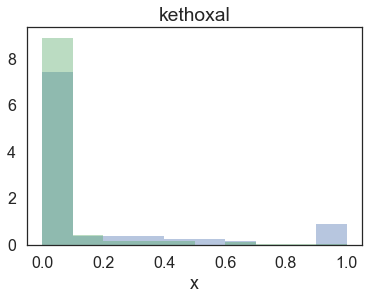

          x  y       a base
46    0.687  0  28.482    G
47    0.260  0  13.710    C
48    0.000  0   6.366    C
49    0.342  1  50.837    A
50    0.224  0  26.236    T
67    0.000  0  31.095    A
68    0.000  0  56.089    C
69    0.000  1  13.343    G
70    0.169  1  52.373    G
72    0.730  1  71.041    C
73    1.000  1  51.026    G
74    1.000  1  52.455    G
78    0.308  1  52.442    A
79    0.089  0  46.092    G
80    0.000  0  65.944    T
81    0.072  1   6.207    G
138   1.000  1  16.175    C
141   1.000  0   8.673    C
143   0.000  0   5.382    T
144   0.000  0   9.901    G
146   0.327  1  20.785    A
151   0.070  0   5.904    T
157   0.000  1   6.033    A
173   0.260  0   6.153    C
174   0.000  0   9.845    A
175   0.000  0  19.290    T
178   0.042  1   9.349    C
182   0.328  1  72.333    G
183   0.476  1  18.402    G
184   0.162  0  54.148    G
...     ... ..     ...  ...
1746  0.000  0   6.869    C
1748  0.000  0  44.307    G
1749  0.000  0  20.028    C
1750  0.000  1  21.8

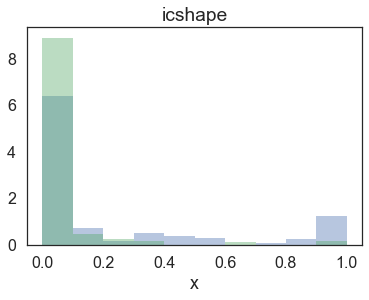

             x  y       a base
46    0.003011  0  28.482    G
47    0.000626  0  13.710    C
48    0.001108  0   6.366    C
49    0.000867  1  50.837    A
50    0.001421  0  26.236    T
67    0.002722  0  31.095    A
68    0.001132  0  56.089    C
69    0.006335  1  13.343    G
70    0.009828  1  52.373    G
72    0.008358  1  71.041    C
73    0.170778  1  51.026    G
74    0.326958  1  52.455    G
78    0.007973  1  52.442    A
79    0.016789  0  46.092    G
80    0.010020  0  65.944    T
81    0.013946  1   6.207    G
138   0.004239  1  16.175    C
141   0.001566  0   8.673    C
143   0.002722  0   5.382    T
144   0.006624  0   9.901    G
146   0.001445  1  20.785    A
151   0.001180  0   5.904    T
157   0.003396  1   6.033    A
173   0.001662  0   6.153    C
174   0.000795  0   9.845    A
175   0.001807  0  19.290    T
178   0.001253  1   9.349    C
182   0.005107  1  72.333    G
183   0.024159  1  18.402    G
184   0.002023  0  54.148    G
...        ... ..     ...  ...
1749  0.

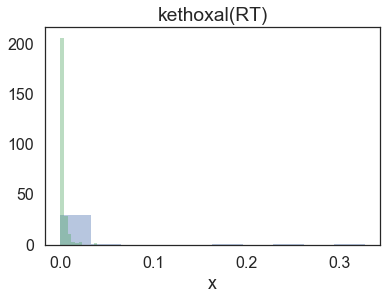

             x  y       a base
46    0.134753  0  28.482    G
47    0.082405  0  13.710    C
48    0.138336  0   6.366    C
49    0.105991  1  50.837    A
50    0.108678  0  26.236    T
67    0.049761  0  31.095    A
68    0.008957  0  56.089    C
69    0.022393  1  13.343    G
70    0.058718  1  52.373    G
72    0.113754  1  71.041    C
73    0.318372  1  51.026    G
74    0.314491  1  52.455    G
78    0.086485  1  52.442    A
79    0.042993  0  46.092    G
80    0.083300  0  65.944    T
81    0.032743  1   6.207    G
138   0.260151  1  16.175    C
141   0.284734  0   8.673    C
143   0.019605  0   5.382    T
144   0.021397  0   9.901    G
146   0.061605  1  20.785    A
151   0.020601  0   5.904    T
157   0.069068  1   6.033    A
173   0.097134  0   6.153    C
174   0.026772  0   9.845    A
175   0.030654  0  19.290    T
178   0.033539  1   9.349    C
182   0.035530  1  72.333    G
183   0.055832  1  18.402    G
184   0.027966  0  54.148    G
...        ... ..     ...  ...
1749  0.

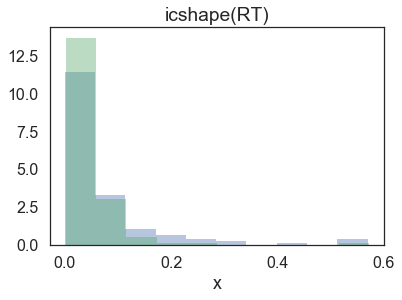

             x  y       a base
46    0.002743  0  28.482    G
47    0.000575  0  13.710    C
48    0.001065  0   6.366    C
49    0.000842  1  50.837    A
50    0.001388  0  26.236    T
67    0.002744  0  31.095    A
68    0.001116  0  56.089    C
69    0.006275  1  13.343    G
70    0.009361  1  52.373    G
72    0.007254  1  71.041    C
73    0.138509  1  51.026    G
74    0.092144  1  52.455    G
78    0.000960  1  52.442    A
79    0.001998  0  46.092    G
80    0.001165  0  65.944    T
81    0.001598  1   6.207    G
138   0.001410  1  16.175    C
141   0.000573  0   8.673    C
143   0.001080  0   5.382    T
144   0.002645  0   9.901    G
146   0.000575  1  20.785    A
151   0.000584  0   5.904    T
157   0.001686  1   6.033    A
173   0.001121  0   6.153    C
174   0.000564  0   9.845    A
175   0.001294  0  19.290    T
178   0.000950  1   9.349    C
182   0.003922  1  72.333    G
183   0.019126  1  18.402    G
184   0.001291  0  54.148    G
...        ... ..     ...  ...
1749  0.

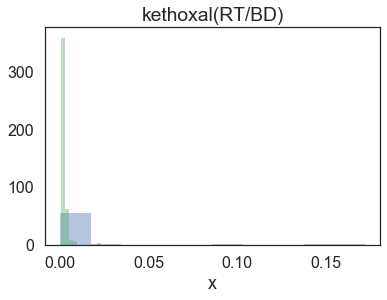

             x  y       a base
46    0.071453  0  28.482    G
47    0.042900  0  13.710    C
48    0.071947  0   6.366    C
49    0.053806  1  50.837    A
50    0.054149  0  26.236    T
67    0.021641  0  31.095    A
68    0.003913  0  56.089    C
69    0.009848  1  13.343    G
70    0.025883  1  52.373    G
72    0.050343  1  71.041    C
73    0.139334  1  51.026    G
74    0.129706  1  52.455    G
78    0.034298  1  52.442    A
79    0.016993  0  46.092    G
80    0.033033  0  65.944    T
81    0.013015  1   6.207    G
138   0.119663  1  16.175    C
141   0.123950  0   8.673    C
143   0.008284  0   5.382    T
144   0.009128  0   9.901    G
146   0.025630  1  20.785    A
151   0.008604  0   5.904    T
157   0.028740  1   6.033    A
173   0.040564  0   6.153    C
174   0.011052  0   9.845    A
175   0.013075  0  19.290    T
178   0.014682  1   9.349    C
182   0.016062  1  72.333    G
183   0.025598  1  18.402    G
184   0.012879  0  54.148    G
...        ... ..     ...  ...
1749  0.

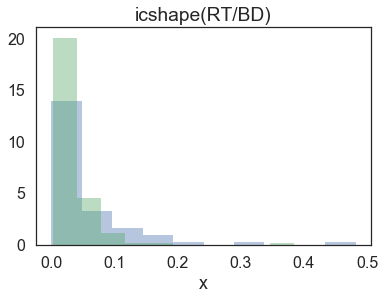

In [151]:
filelist = ['kethoxal', 'icshape', 'kethoxal(RT)', 'icshape(RT)', 'kethoxal(RT/BD)', 'icshape(RT/BD)']

X_test = [kethoxal_df, icshape_df, kethoxal_rt_df, icshape_rt_df, kethoxal_rt_div_bd_df, icshape_rt_div_bd_df]

filelist = filelist[0:]
X_test = X_test[0:]

fpr_list = []
tpr_list = []
roc_auc_list = []

for i in range(len(X_test)):
    X_test[i]['y'] = mouse_ct_18S_new
    X_test[i]['a'] = pd.Series(mouse_acces_ls)
    X_test[i]['base'] = list(fa_dict_rRNA_mouse['18S'])
    X_clean = X_test[i].dropna()
    X_select = X_clean[X_clean.a>=5]
    X_select = X_select[X_select['x']>=0]
#     X_select = X_select[X_select['base']=='G']
    print X_select
    print X_select['y'].value_counts()
    fpr,tpr,_ = roc_curve(X_select['y'],X_select['x'])
    ml_125_ss = X_select[X_select.y==1]
    ml_125_ds = X_select[X_select.y==0]
    print(ml_125_ss.describe())
    print(ml_125_ds.describe())
    sns.distplot(ml_125_ss.dropna()['x'],norm_hist=True,kde=False, bins=10)
    sns.distplot(ml_125_ds.dropna()['x'],norm_hist=True,kde=False, bins=10)
    plt.title(filelist[i])
    plt.show()
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(auc(fpr_list[i],tpr_list[i]))

0
1
2
3
4
5


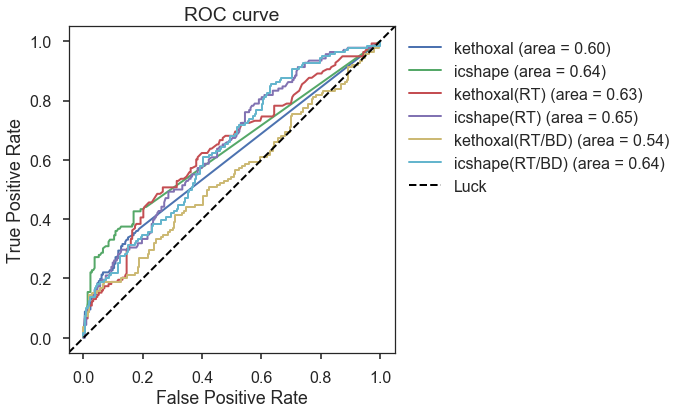

In [152]:
plt.figure()
lw = 2

# filelist = ['kethoxal', 'icshape']
with sns.axes_style("ticks"):
    fig,ax=plt.subplots(figsize=(6,6))
for i in range(len(X_test)):
    print (i)
    plt.plot(fpr_list[i],tpr_list[i],lw = lw,label = '%s (area = %0.2f)' %(filelist[i],roc_auc_list[i]))
plt.plot([-0.05, 1.05], [-0.05, 1.05], color='black', lw=lw, linestyle='--',label='Luck')
ax.axis('square')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
# plt.legend(loc='best')
# plt.show()
# plt.tight_layout()
plt.savefig('18s_AUC.pdf')

In [77]:
out_dict_kethoxal_SRP = read_icshape_out('kethoxalseq_noTreat.T1t20.ENSMUST00000174924.2.out')
out_dict_icshape_SRP = read_icshape_out('icshape.ENSMUST00000174924.out')
out_dict_CIRSseq_SRP = read_icshape_out('CIRSseq.ENSMUST00000174924.out')

kethoxal_SRP = out_dict_kethoxal_SRP['ENSMUST00000174924']['reactivity_ls']
icshape_SRP = out_dict_icshape_SRP['ENSMUST00000174924']['reactivity_ls']
CIRSseq_SRP = out_dict_CIRSseq_SRP['ENSMUST00000174924']['reactivity_ls']

print len(kethoxal_SRP), len(icshape_SRP), len(CIRSseq_SRP)

kethoxal_SRP = [np.nan if i == 'NULL' else float(i) for i in kethoxal_SRP]
kethoxal_df_SRP = pd.DataFrame({'x':kethoxal_SRP})

icshape_SRP = [np.nan if i == 'NULL' else float(i) for i in icshape_SRP]
icshape_df_SRP = pd.DataFrame({'x':icshape_SRP})

CIRSseq_SRP = [np.nan if i == 'NULL' else float(i) for i in CIRSseq_SRP]
CIRSseq_df_SRP = pd.DataFrame({'x':CIRSseq_SRP})

300 300 300


In [55]:
dot_dict_SRP = read_dot('./RNAstrand/mouse_SRP.dot')
print dot_dict_SRP['seq'], len(dot_dict_SRP['seq'])
print dot_dict_SRP['dotbracket'], len(dot_dict_SRP['dotbracket'])

dot_dict_SRP_new = list(dot_dict_SRP['dotbracket'].replace('.','1').replace('(','0').replace(')','0'))
print dot_dict_SRP_new, len(dot_dict_SRP_new)

GCCGGGCGCGGTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGGTGTCCGCACTAAGTTCGGCATCAATATGGTGACCTCCCGGGAGCGGGGGACCACCAGGTTGCCTAAGGAGGGGTGAACCGGCCCAGGTCGGAAACGGAGCAGGTCAAAACTCCCGTGCTGATCAGTAGTGGGATCGCGCCTGTGAATAGCCACTGCACTCCAGCCTGGGCAACATAGCGAGACCCCGTCTCTTTT 302
((((((((.(......).)))))....((((........))))))).(((((.((....(((((...(((((((....(((((.(((((((.(((((.(....(((((((((.(((((.(.(((((((((((.(((((..((((((....))))))..))))).))))((...)).(((((.....((((....(((....)))....))))...))))).))))))).)..)))))))...))))))).).)))))))))))).)))))))))))).....)))))...)).))))).... 302
['0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', 

In [79]:
fa_dict_SRP = Fasta('ENSMUST00000174924.2.fa', key_fn=lambda key:key.split("\t")[0])
print fa_dict_SRP['ENSMUST00000174924.2'], len(fa_dict_SRP['ENSMUST00000174924.2'])

GCCGGGCGCGGTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGGTGTCCGCACTAAGTTCGGCATCAATATGGTGACCTCCCGGGAGCGGGGGACCACCAGGTTGCCTAAGGAGGGGTGAACCGGCCCAGGTCGGAAACGGAGCAGGTCAAAACTCCCGTGCTGATCAGTAGTGGGATCGCGCCTGTGAATAGCCACTGCACTCCAGCCTGGGCAACATAGCGAGACCCCGTCTCTT 300


In [80]:
print kethoxal_df_SRP.head()
# print icshape_df_SRP['x']

    x  y
0 NaN  0
1 NaN  0
2 NaN  0
3 NaN  0
4 NaN  0


        x  y base
7   0.000  0    G
9   0.000  0    G
10  0.194  1    G
12  0.360  1    G
13  0.571  1    G
0    68
1    24
Name: y, dtype: int64
               x   y
count  24.000000  24
mean    0.494375   1
std     0.401397   0
min     0.000000   1
25%     0.096750   1
50%     0.443500   1
75%     1.000000   1
max     1.000000   1
               x   y
count  68.000000  68
mean    0.264588   0
std     0.351116   0
min     0.000000   0
25%     0.000000   0
50%     0.068000   0
75%     0.392250   0
max     1.000000   0


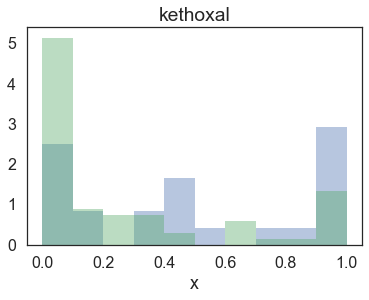

        x  y base
7   0.485  0    G
9   0.761  0    G
10  0.134  1    G
12  0.246  1    G
13  0.859  1    G
0    68
1    24
Name: y, dtype: int64
               x   y
count  24.000000  24
mean    0.284208   1
std     0.281708   0
min     0.000000   1
25%     0.087750   1
50%     0.149500   1
75%     0.393000   1
max     1.000000   1
               x   y
count  68.000000  68
mean    0.194515   0
std     0.168277   0
min     0.000000   0
25%     0.070750   0
50%     0.151500   0
75%     0.293000   0
max     0.761000   0


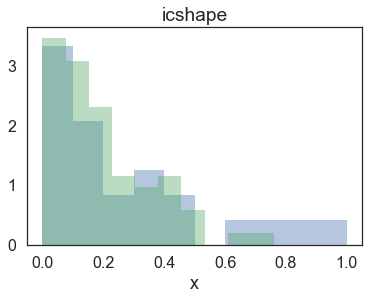

       x  y base
0  0.828  0    G
3  0.223  0    G
4  0.187  0    G
5  0.498  0    G
7  0.598  0    G
0    54
1    18
Name: y, dtype: int64
               x   y
count  18.000000  18
mean    0.336944   1
std     0.221870   0
min     0.072000   1
25%     0.184750   1
50%     0.289500   1
75%     0.462500   1
max     0.900000   1
               x   y
count  54.000000  54
mean    0.383185   0
std     0.267648   0
min     0.039000   0
25%     0.213500   0
50%     0.295000   0
75%     0.492500   0
max     1.000000   0


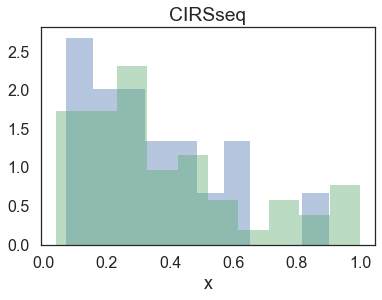

In [81]:
filelist = ['kethoxal', 'icshape', 'CIRSseq']

X_test = [kethoxal_df_SRP, icshape_df_SRP, CIRSseq_df_SRP]

fpr_list = []
tpr_list = []
roc_auc_list = []

for i in range(len(X_test)):
    X_test[i]['y'] = map(int, dot_dict_SRP_new[0:300])
    X_test[i]['base'] = list(fa_dict_SRP['ENSMUST00000174924.2'])
    X_clean = X_test[i].dropna()
    X_select = X_clean[X_clean['x']>=0]
    X_select = X_select[X_select['base']=='G']
    print X_select.head()
    print X_select['y'].value_counts()
    fpr,tpr,_ = roc_curve(X_select['y'],X_select['x'])
    ml_125_ss = X_select[X_select.y==1]
    ml_125_ds = X_select[X_select.y==0]
    print(ml_125_ss.describe())
    print(ml_125_ds.describe())
    sns.distplot(ml_125_ss.dropna()['x'],norm_hist=True,kde=False, bins=10)
    sns.distplot(ml_125_ds.dropna()['x'],norm_hist=True,kde=False, bins=10)
    plt.title(filelist[i])
    plt.show()
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(auc(fpr_list[i],tpr_list[i]))

0
1
2


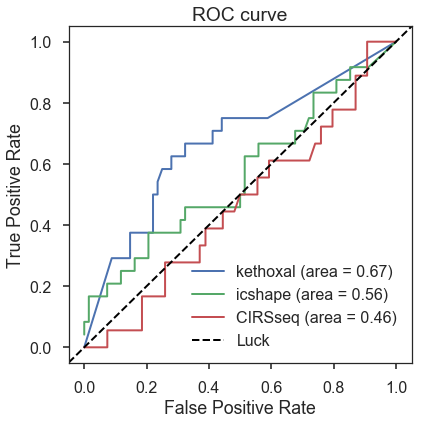

In [82]:
plt.figure()
lw = 2

filelist = ['kethoxal', 'icshape', 'CIRSseq']
with sns.axes_style("ticks"):
    fig,ax=plt.subplots(figsize=(6,6))
for i in range(len(X_test)):
    print (i)
    plt.plot(fpr_list[i],tpr_list[i],lw = lw,label = '%s (area = %0.2f)' %(filelist[i],roc_auc_list[i]))
plt.plot([-0.05, 1.05], [-0.05, 1.05], color='black', lw=lw, linestyle='--',label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(loc='best')
# plt.show()
plt.tight_layout()
plt.savefig('SRP_AUC.pdf')

In [86]:
out_dict_kethoxal_Riob = read_icshape_out('kethoxalseq_noTreat.T1t20.ENSMUST00000175096.1.out')
out_dict_icshape_Riob = read_icshape_out('icshape.ENSMUST00000175096.out')
out_dict_CIRSseq_Riob = read_icshape_out('CIRSseq.ENSMUST00000175096.out')

kethoxal_Riob = out_dict_kethoxal_Riob['ENSMUST00000175096']['reactivity_ls']
icshape_Riob = out_dict_icshape_Riob['ENSMUST00000175096']['reactivity_ls']
CIRSseq_Riob = out_dict_CIRSseq_Riob['ENSMUST00000175096']['reactivity_ls']

print len(kethoxal_Riob), len(icshape_Riob), len(CIRSseq_Riob)

kethoxal_Riob = [np.nan if i == 'NULL' else float(i) for i in kethoxal_Riob]
kethoxal_df_Riob = pd.DataFrame({'x':kethoxal_Riob})

icshape_Riob = [np.nan if i == 'NULL' else float(i) for i in icshape_Riob]
icshape_df_Riob = pd.DataFrame({'x':icshape_Riob})

CIRSseq_Riob = [np.nan if i == 'NULL' else float(i) for i in CIRSseq_Riob]
CIRSseq_df_Riob = pd.DataFrame({'x':CIRSseq_Riob})

319 319 319


In [60]:
dot_dict_Riob = read_dot('./RNAstrand/mouse_RiboRRNA.dot')
print dot_dict_Riob['seq'], len(dot_dict_Riob['seq'])
print dot_dict_Riob['dotbracket'], len(dot_dict_Riob['dotbracket'])

# dot_dict_SRP_new = list(dot_dict_SRP['dotbracket'].replace('.','1').replace('(','0').replace(')','0'))
# print dot_dict_SRP_new, len(dot_dict_SRP_new)

AGTGGGCGGAGGAAGCTCATCAGCGGGGCCACGTGCTGAGTGCTCGTCACTCTTCGGCCCCTGGGAAGGTCTGAGACTNGGGCCTCCCGCGGCCCTAACCGGGCTCTCCCCGAGCGGGGAGGTGAGTTCCCAGAGAGCAGGGCTCTACGCTTGGGCAGACTGGGCAGGAGAAAAGGCCCCGAGTTCGGGGCGGATGCCTCCCTCGCCGGAGCTTGGAACAGACTCACGGCCAGCAGTGCGAGTTCAATGGCTGAGGTGAGGCACCTCCCGGGCCTCATAACCCAATTCA 289
...............((((.((..(((((........(((((.....)))))....)))))))........<<<<.....((((......(((((.....)))))((((((....))))))(((((((...........(((....................................................................))).......)))))))))))....................))))((((((((.(....))))))))).......>>>> 289


In [73]:
fa = 'GGCGGAGGAAGCTCATCAGCGGGGCCACGTGCTGAGTGCGTGTCACTCTTCGGCCCCTGGGAAGGTCTGAGACTTGGGCCTCCCGCGGCCCTAACCGGGCTCTCCCCGAGCGGGGAGGTGAGTTCCCAGAGAGCAGGGCTCTACGCTTGGGCAGACTGGGCAGGAGAAGCCCCGAGTCGGGGCGGATGCCTCCCTCGCCGGAGCGGATGCCTCCCTCGCCGGAGCTTGGAACAGACTCACGGCCAGCAGTGCGAGTTCAATGGCTGAGGTGAGGCACCTCCCGGGCCTCATAACCCAATTCA'
dot= 'GGCGGAGGAAGCTCATCAGCGGGGCCACGTGCTGAGTGCTCGTCACTCTTCGGCCCCTGGGAAGGTCTGAGACTNGGGCCTCCCGCGGCCCTAACCGGGCTCTCCCCGAGCGGGGAGGTGAGTTCCCAGAGAGCAGGGCTCTACGCTTGGGCAGACTGGGCAGGAGAAAA---G-GCCC---CG-A-G--T---TCG--GG-GCGGATGCCTCCCTCGCCGGAGCTTGGAACAGACTCACGGCCAGCAGTGCGAGTTCAATGGCTGAGGTGAGGCACCTCCCGGGCCTCATAACCCAATTCA'

# a_ls = list(accessibility['c'])
# print "original", len(a_ls)

dot_dict_Riob_new = list(dot_dict_Riob['dotbracket'].replace('.','1').replace('(','0').replace(')','0').replace('>','0').replace('<','0'))

new_ls = []

n = 0
for i,j in zip(fa, dot):
    if j != '-':
        n += 1
#         print n
    if i != '-':
        if j == '-':
            new_ls.append('1')
        else:
            new_ls.append(dot_dict_Riob_new[4:][n-1])
    
print "converted 1", len(new_ls)

dot_dict_Riob_new = new_ls + ['1']*17
print len(dot_dict_Riob_new)

converted 1 302
319


In [83]:
fa_dict_Ribo = Fasta('ENSMUST00000175096.1.fa', key_fn=lambda key:key.split("\t")[0])
print fa_dict_Ribo['ENSMUST00000175096.1'], len(fa_dict_Ribo['ENSMUST00000175096.1'])

GGCGGAGGAAGCTCATCAGCGGGGCCACGTGCTGAGTGCGTGTCACTCTTCGGCCCCTGGGAAGGTCTGAGACTTGGGCCTCCCGCGGCCCTAACCGGGCTCTCCCCGAGCGGGGAGGTGAGTTCCCAGAGAGCAGGGCTCTACGCTTGGGCAGACTGGGCAGGAGAAGCCCCGAGTCGGGGCGGATGCCTCCCTCGCCGGAGCGGATGCCTCCCTCGCCGGAGCTTGGAACAGACTCACGGCCAGCAGTGCGAGTTCAATGGCTGAGGTGAGGCACCTCCCGGGCCTCATAACCCAATTCAGACTACTCTCCCCCGCC 319


        x  y base
6   0.000  1    G
7   0.000  1    G
10  0.317  1    G
18  0.000  1    G
20  0.000  0    G
1    35
0    31
Name: y, dtype: int64
               x   y
count  35.000000  35
mean    0.274400   1
std     0.360911   0
min     0.000000   1
25%     0.000000   1
50%     0.111000   1
75%     0.482000   1
max     1.000000   1
               x   y
count  31.000000  31
mean    0.146065   0
std     0.254470   0
min     0.000000   0
25%     0.000000   0
50%     0.000000   0
75%     0.250000   0
max     1.000000   0


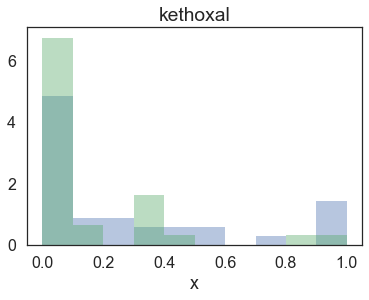

        x  y base
6   0.659  1    G
7   0.273  1    G
10  0.427  1    G
18  0.152  1    G
20  0.000  0    G
1    60
0    42
Name: y, dtype: int64
               x   y
count  60.000000  60
mean    0.231350   1
std     0.222585   0
min     0.000000   1
25%     0.052750   1
50%     0.150500   1
75%     0.355500   1
max     0.905000   1
               x   y
count  42.000000  42
mean    0.178619   0
std     0.191663   0
min     0.000000   0
25%     0.041000   0
50%     0.103500   0
75%     0.229500   0
max     0.747000   0


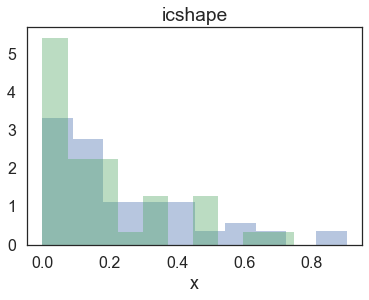

       x  y base
0  1.000  1    G
1  0.550  1    G
3  0.571  1    G
4  0.280  1    G
6  0.245  1    G
1    46
0    35
Name: y, dtype: int64
               x   y
count  46.000000  46
mean    0.330174   1
std     0.224750   0
min     0.020000   1
25%     0.211250   1
50%     0.295000   1
75%     0.370000   1
max     1.000000   1
               x   y
count  35.000000  35
mean    0.237857   0
std     0.166484   0
min     0.012000   0
25%     0.118000   0
50%     0.206000   0
75%     0.315000   0
max     0.703000   0


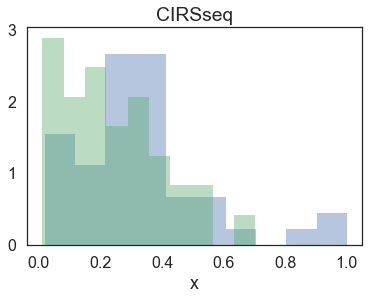

In [87]:
filelist = ['kethoxal', 'icshape', 'CIRSseq']

X_test = [kethoxal_df_Riob, icshape_df_Riob, CIRSseq_df_Riob]

fpr_list = []
tpr_list = []
roc_auc_list = []

for i in range(len(X_test)):
    X_test[i]['y'] = map(int, dot_dict_Riob_new)
    X_test[i]['base'] = list(fa_dict_Ribo['ENSMUST00000175096.1'])
    X_clean = X_test[i].dropna()
    X_select = X_clean[X_clean['x']>=0]
    X_select = X_select[X_select['base']=='G']
    print X_select.head()
    print X_select['y'].value_counts()
    fpr,tpr,_ = roc_curve(X_select['y'],X_select['x'])
    ml_125_ss = X_select[X_select.y==1]
    ml_125_ds = X_select[X_select.y==0]
    print(ml_125_ss.describe())
    print(ml_125_ds.describe())
    sns.distplot(ml_125_ss.dropna()['x'],norm_hist=True,kde=False, bins=10)
    sns.distplot(ml_125_ds.dropna()['x'],norm_hist=True,kde=False, bins=10)
    plt.title(filelist[i])
    plt.show()
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(auc(fpr_list[i],tpr_list[i]))

0
1
2


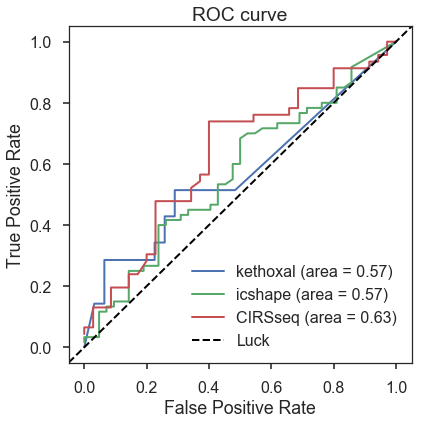

In [88]:
plt.figure()
lw = 2

filelist = ['kethoxal', 'icshape', 'CIRSseq']
with sns.axes_style("ticks"):
    fig,ax=plt.subplots(figsize=(6,6))
for i in range(len(X_test)):
    print (i)
    plt.plot(fpr_list[i],tpr_list[i],lw = lw,label = '%s (area = %0.2f)' %(filelist[i],roc_auc_list[i]))
plt.plot([-0.05, 1.05], [-0.05, 1.05], color='black', lw=lw, linestyle='--',label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(loc='best')
# plt.show()
plt.tight_layout()
plt.savefig('Ribo_AUC.pdf')

In [71]:
# for n,i in enumerate(new_ls):
#     print n, i